# Импорт библиотек и функции

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [40]:
def plot_training_curves(history):

  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  epochs = [i+1 for i in range(len(tr_acc))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_acc, 'r', label='Точность обучения')
  plt.plot(epochs, val_acc, 'g', label='Точность валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_performance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  model_roc_auc = roc_auc_score(y_true, y_probabilities)


  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  preformance_scores = {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'auc_score': model_roc_auc,
  }

  return preformance_scores


def plot_roc_curve(y_test, y_prob):
    auc = roc_auc_score(y_test, y_prob)
    fper, tper, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fper, tper, label=f"AUC = {round(auc, 3)}")
    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("График ROC-кривой", fontsize=14, fontweight="bold")
    plt.grid()
    plt.legend(loc=4)
    plt.show()

# Загрузка набора данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 30 05:06 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [6]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 70.7MB/s]


# Чтение данных

In [8]:
# разархивирование данных
!unzip "/content/diabetes-health-indicators-dataset.zip" -d "/content/diabetes"

Archive:  /content/diabetes-health-indicators-dataset.zip
  inflating: /content/diabetes/diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes/diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes/diabetes_binary_health_indicators_BRFSS2015.csv  


In [9]:
df = pd.read_csv('/content/diabetes/diabetes_binary_5050split_health_indicators_BRFSS2015.csv') # читаем данные в перменную df
df.head() # выводим первые 5 строк

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [13]:
df.shape

(70692, 22)

# Исследование данных

In [10]:
df.describe() # информация о числовых характеристиках переменных

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [11]:
df.info() # информация о пропущенных знначениях и типах переменной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [12]:
df.duplicated().sum()

1635

In [14]:
df = df.drop_duplicates()
df.duplicated().sum()

0

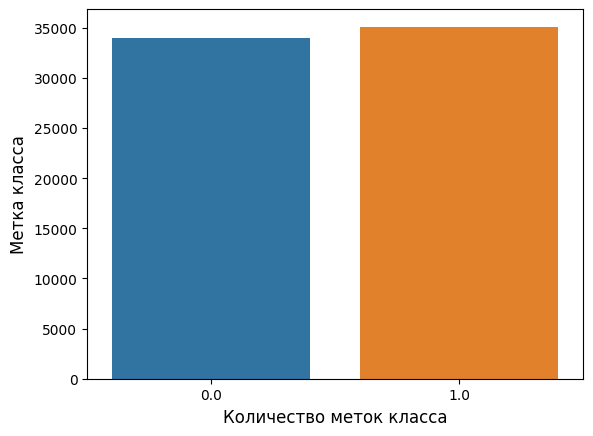

In [15]:
# визуализация количества меток класса
sns.countplot(x=df['Diabetes_binary'] ,data=df)
plt.xlabel("Количество меток класса", fontsize=12)
plt.ylabel("Метка класса", fontsize=12)
plt.show()

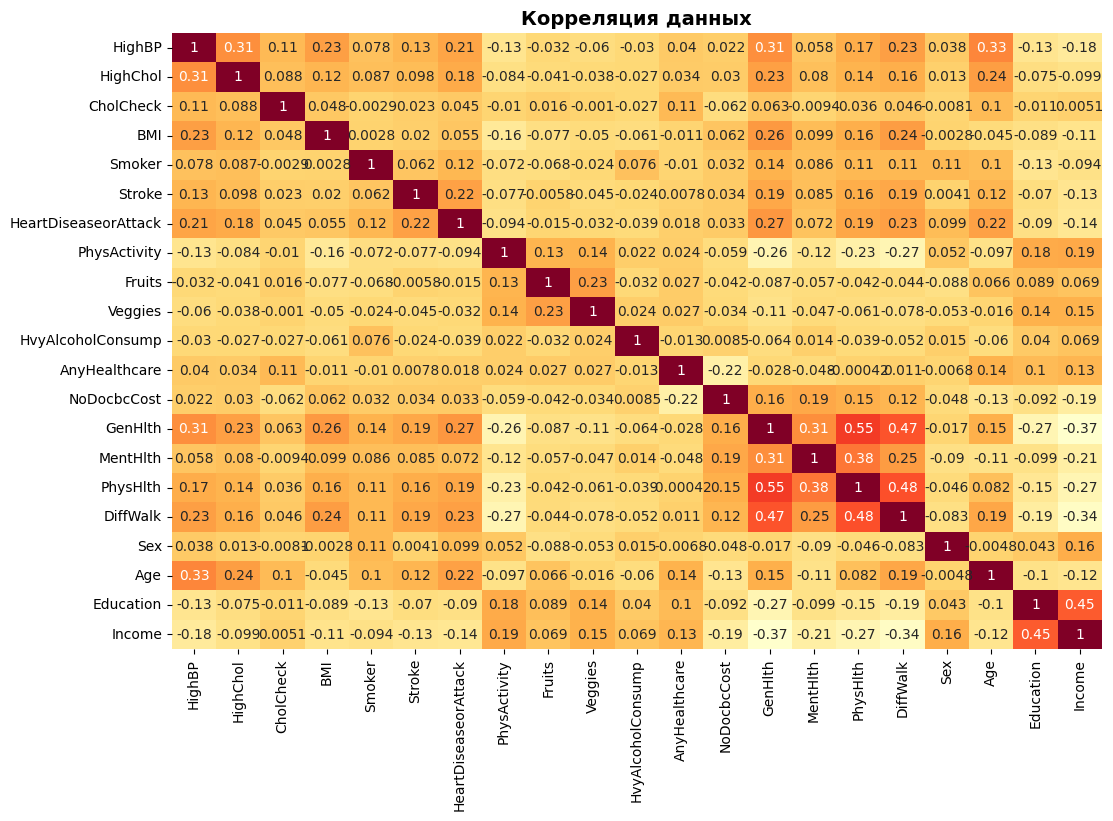

In [16]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.drop("Diabetes_binary", axis=1).corr(), annot=True, cmap ='YlOrRd', cbar=False)
plt.title("Корреляция данных", fontsize=14, fontweight="bold");

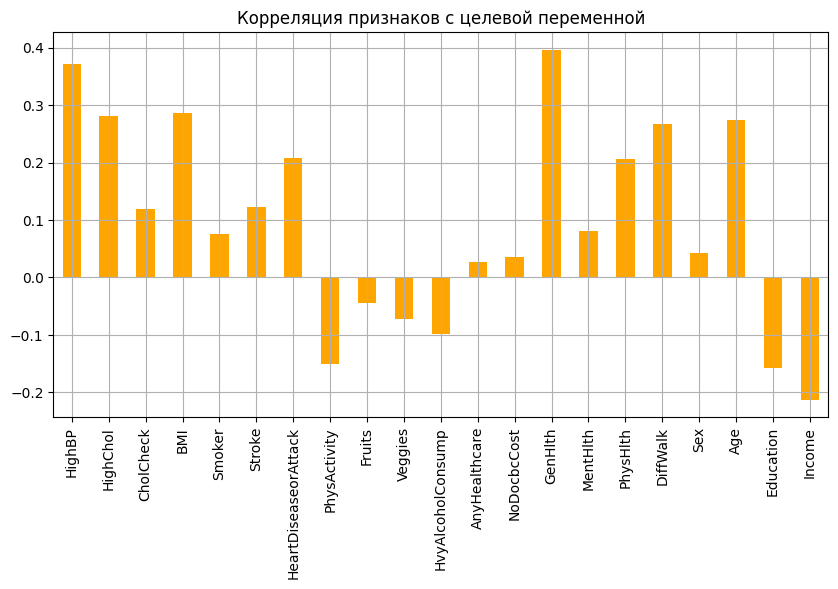

In [17]:
df.drop('Diabetes_binary', axis=1).corrwith(df.Diabetes_binary).plot(kind='bar',
                                                                     grid=True,
                                                                     figsize=(10, 5),
                                                                     title="Корреляция признаков с целевой переменной",
                                                                     color="orange");

# Деление на выборки

In [26]:
# делим выборку на тренировочную и тестовую
X = df.drop(['Diabetes_binary'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['Diabetes_binary'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [27]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (44196, 21)
Размер тестовой выборки: (13812, 21)
Размер валидационной выборки: (11049, 21)


In [28]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

In [29]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [31]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [32]:
# компиляция модели
model1.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                264       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 277 (1.08 KB)
Trainable params: 277 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [33]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
1382/1382 [==============================] - 4s 2ms/step - loss: 0.5412 - accuracy: 0.7231 - val_loss: 0.5185 - val_accuracy: 0.7436
Epoch 2/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5129 - accuracy: 0.7460 - val_loss: 0.5133 - val_accuracy: 0.7471
Epoch 3/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5093 - accuracy: 0.7493 - val_loss: 0.5109 - val_accuracy: 0.7462
Epoch 4/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5076 - accuracy: 0.7507 - val_loss: 0.5097 - val_accuracy: 0.7494
Epoch 5/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5067 - accuracy: 0.7505 - val_loss: 0.5090 - val_accuracy: 0.7474
Epoch 6/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5062 - accuracy: 0.7509 - val_loss: 0.5084 - val_accuracy: 0.7450
Epoch 7/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5058 - accuracy: 0.7519 - val_loss: 0.5084 - val_accuracy:

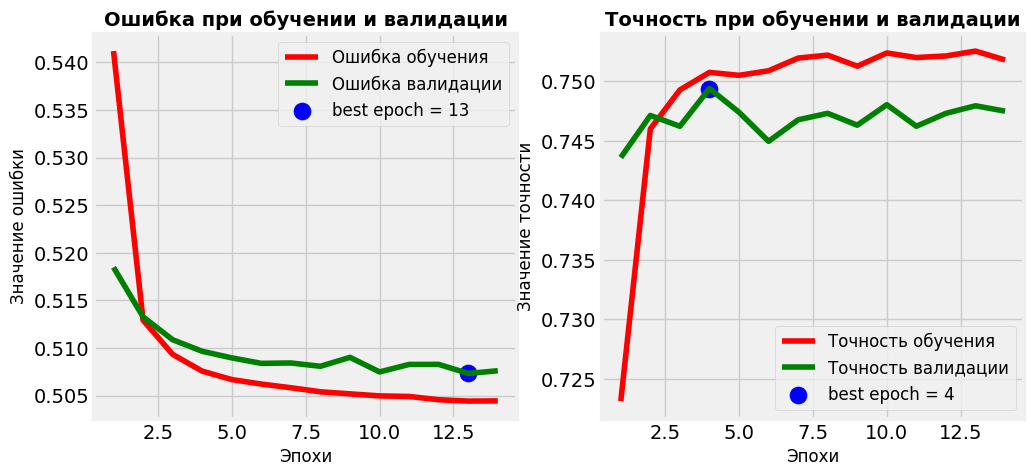

In [34]:
plot_training_curves(history1)

In [35]:
y_predicted_prob = model1.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

432/432 [==============================] - 1s 3ms/step


In [37]:
model1_performance = generate_performance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7444
Precision_score:	0.7405
Recall_score:		0.7879
AUC Score:		0.8206


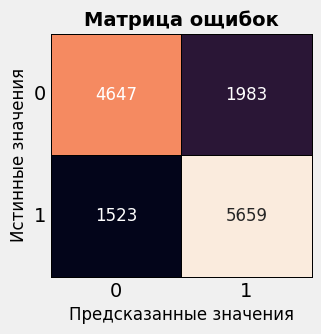

In [38]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

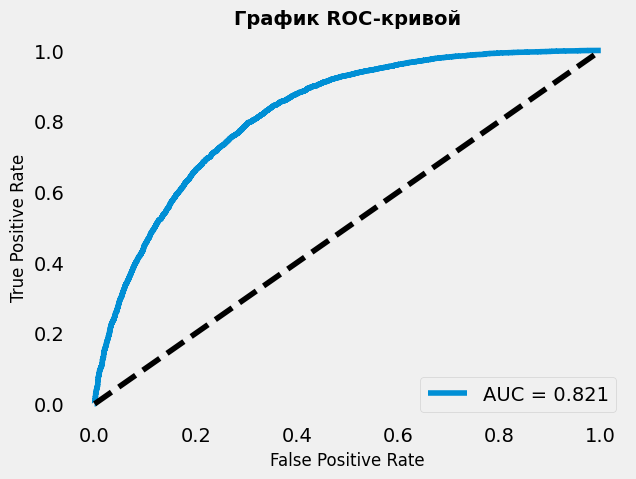

In [41]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [42]:
model2 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [43]:
# компиляция модели
model2.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                704       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19457 (76.00 KB)
Trainable params: 19457 (76.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [44]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
1382/1382 [==============================] - 5s 3ms/step - loss: 0.5266 - accuracy: 0.7372 - val_loss: 0.5127 - val_accuracy: 0.7444
Epoch 2/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5112 - accuracy: 0.7493 - val_loss: 0.5100 - val_accuracy: 0.7450
Epoch 3/50
1382/1382 [==============================] - 5s 3ms/step - loss: 0.5078 - accuracy: 0.7512 - val_loss: 0.5103 - val_accuracy: 0.7420
Epoch 4/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5061 - accuracy: 0.7527 - val_loss: 0.5092 - val_accuracy: 0.7431
Epoch 5/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5044 - accuracy: 0.7542 - val_loss: 0.5104 - val_accuracy: 0.7455
Epoch 6/50
1382/1382 [==============================] - 6s 4ms/step - loss: 0.5022 - accuracy: 0.7541 - val_loss: 0.5114 - val_accuracy: 0.7442
Epoch 7/50
1382/1382 [==============================] - 3s 3ms/step - loss: 0.5014 - accuracy: 0.7566 - val_loss: 0.5094 - val_accuracy:

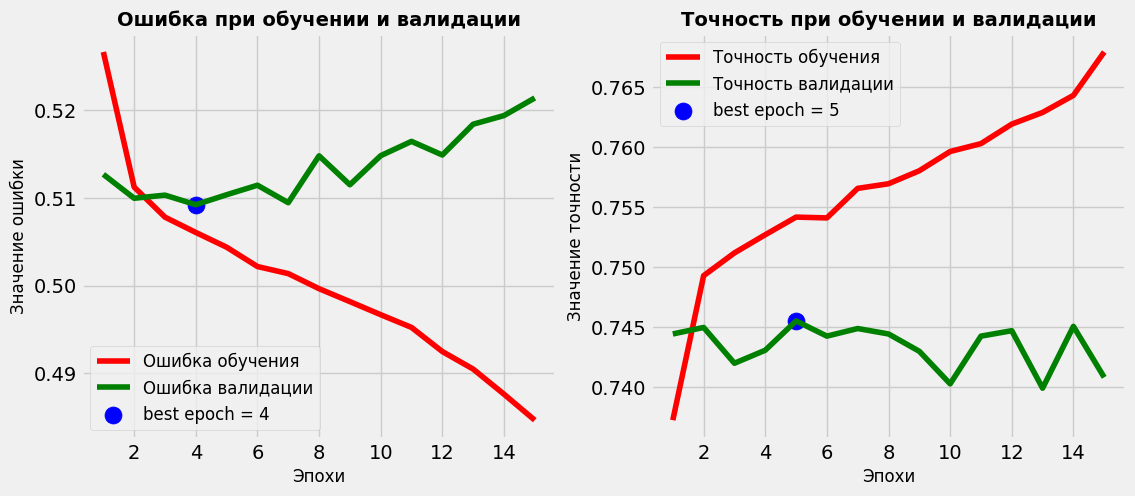

In [45]:
plot_training_curves(history2)

In [46]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

432/432 [==============================] - 3s 6ms/step


In [47]:
model2_performance = generate_performance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7405
Precision_score:	0.7388
Recall_score:		0.7796
AUC Score:		0.8146


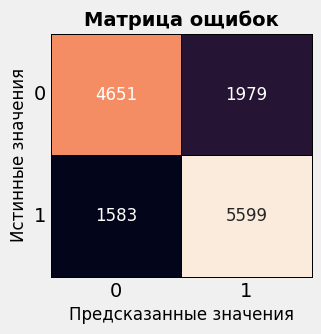

In [48]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

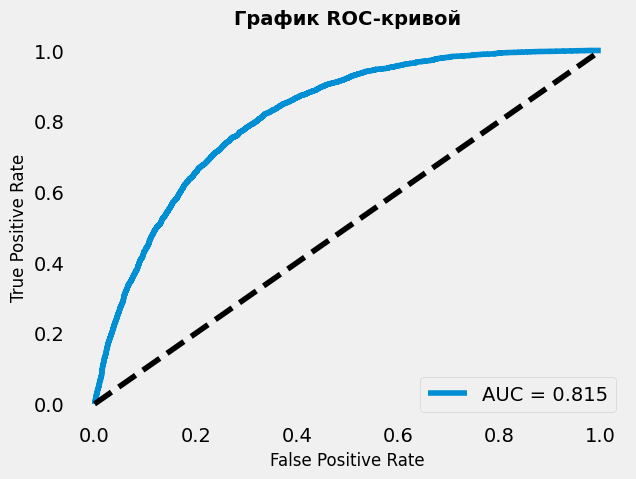

In [49]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 3

In [50]:
model3 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

In [51]:
# компиляция модели
model3.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 32)                704       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

### Обучение

In [52]:
history3 = model3.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
1382/1382 [==============================] - 11s 5ms/step - loss: 0.5437 - accuracy: 0.7288 - val_loss: 0.5162 - val_accuracy: 0.7449
Epoch 2/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5217 - accuracy: 0.7452 - val_loss: 0.5113 - val_accuracy: 0.7475
Epoch 3/50
1382/1382 [==============================] - 5s 3ms/step - loss: 0.5185 - accuracy: 0.7477 - val_loss: 0.5116 - val_accuracy: 0.7469
Epoch 4/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5164 - accuracy: 0.7481 - val_loss: 0.5116 - val_accuracy: 0.7467
Epoch 5/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5146 - accuracy: 0.7487 - val_loss: 0.5106 - val_accuracy: 0.7469
Epoch 6/50
1382/1382 [==============================] - 5s 4ms/step - loss: 0.5127 - accuracy: 0.7487 - val_loss: 0.5119 - val_accuracy: 0.7469
Epoch 7/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5118 - accuracy: 0.7506 - val_loss: 0.5120 - val_accuracy

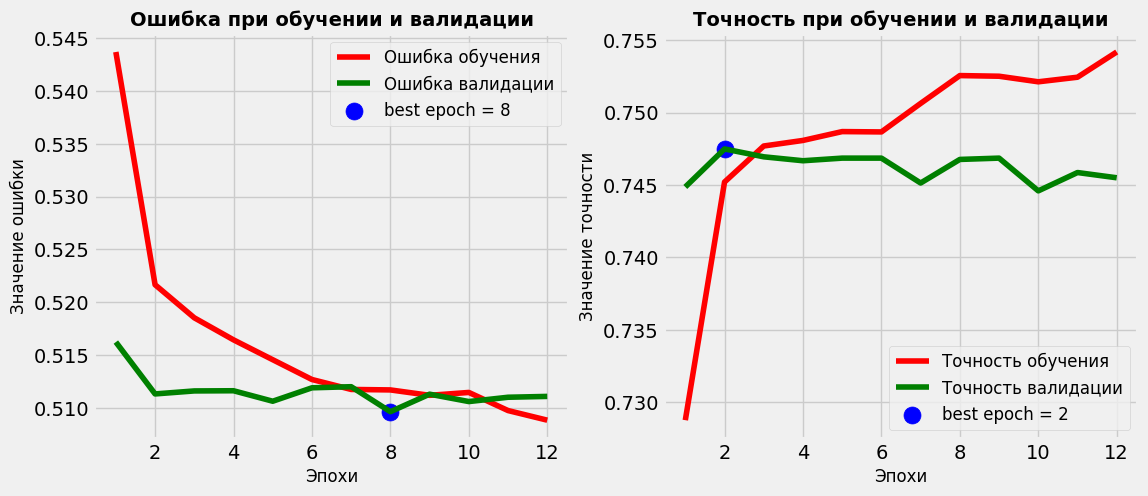

In [53]:
plot_training_curves(history3)

In [54]:
y_predicted_prob = model3.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

432/432 [==============================] - 2s 4ms/step


In [55]:
model3_performance = generate_performance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7444
Precision_score:	0.7497
Recall_score:		0.7657
AUC Score:		0.8205


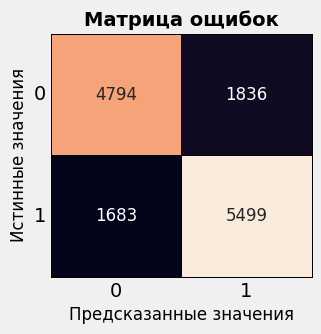

In [56]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

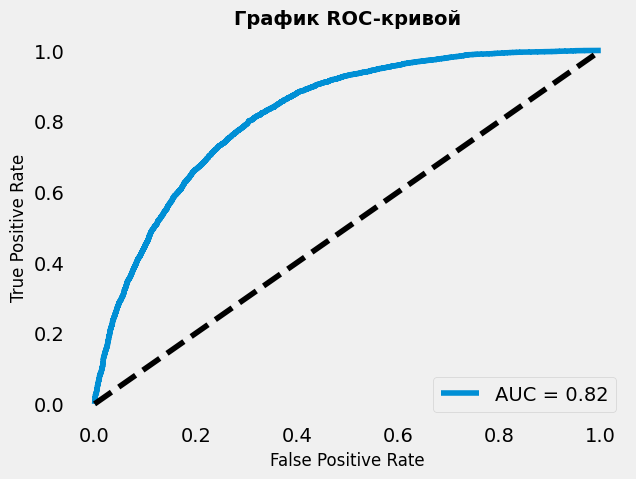

In [57]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 4

In [58]:
model4 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

In [59]:
# компиляция модели
model4.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                704       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 128)               4224      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 32)               

### Обучение

In [60]:
history4 = model4.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
1382/1382 [==============================] - 10s 5ms/step - loss: 0.5396 - accuracy: 0.7341 - val_loss: 0.5239 - val_accuracy: 0.7435
Epoch 2/50
1382/1382 [==============================] - 5s 3ms/step - loss: 0.5227 - accuracy: 0.7462 - val_loss: 0.5146 - val_accuracy: 0.7442
Epoch 3/50
1382/1382 [==============================] - 6s 4ms/step - loss: 0.5198 - accuracy: 0.7474 - val_loss: 0.5093 - val_accuracy: 0.7479
Epoch 4/50
1382/1382 [==============================] - 5s 3ms/step - loss: 0.5173 - accuracy: 0.7500 - val_loss: 0.5103 - val_accuracy: 0.7452
Epoch 5/50
1382/1382 [==============================] - 6s 4ms/step - loss: 0.5164 - accuracy: 0.7493 - val_loss: 0.5107 - val_accuracy: 0.7449
Epoch 6/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5152 - accuracy: 0.7513 - val_loss: 0.5131 - val_accuracy: 0.7443
Epoch 7/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5144 - accuracy: 0.7507 - val_loss: 0.5135 - val_accuracy

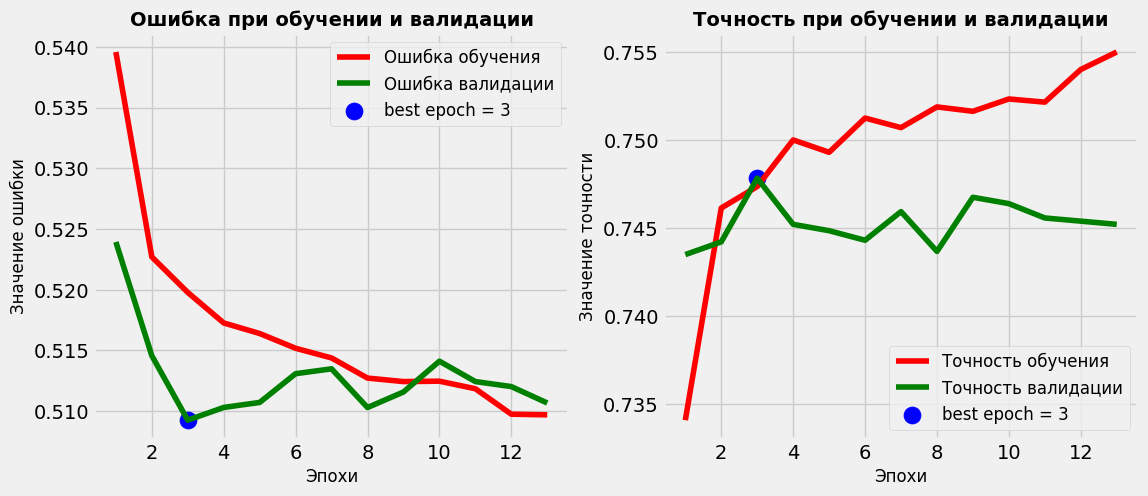

In [61]:
plot_training_curves(history4)

In [62]:
y_predicted_prob = model4.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

432/432 [==============================] - 1s 2ms/step


In [63]:
model4_performance = generate_performance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7451
Precision_score:	0.7376
Recall_score:		0.7977
AUC Score:		0.8194


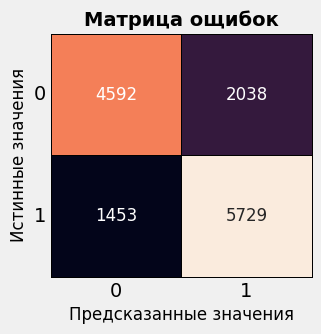

In [64]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

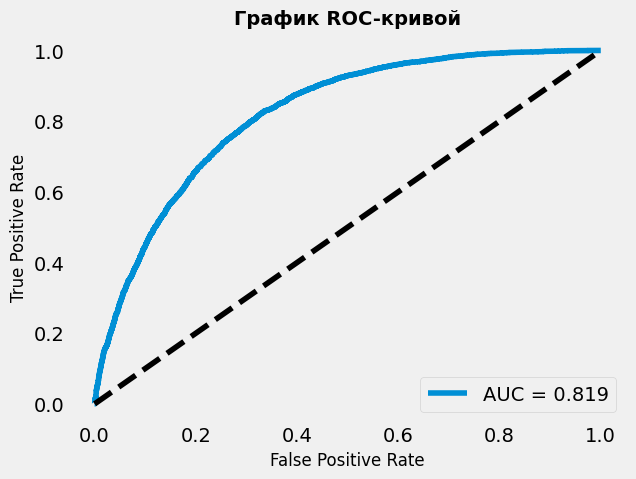

In [65]:
plot_roc_curve(y_test, y_predicted_prob)

# Новые признаки

In [66]:
corr = df.corr()

In [74]:
th=0.22

corr_th = corr["Diabetes_binary"][abs(corr["Diabetes_binary"]) > th]
corr_th

Diabetes_binary    1.000000
HighBP             0.372048
HighChol           0.281399
BMI                0.285643
GenHlth            0.396571
DiffWalk           0.267082
Age                0.274550
Name: Diabetes_binary, dtype: float64

In [75]:
new_df = df.drop(corr["Diabetes_binary"][abs(corr["Diabetes_binary"]) <= th].keys(), axis=1)
new_df.head()

,Diabetes_binary,HighBP,HighChol,BMI,GenHlth,DiffWalk,Age
0,0.0,1.0,0.0,26.0,3.0,0.0,4.0
1,0.0,1.0,1.0,26.0,3.0,0.0,12.0
2,0.0,0.0,0.0,26.0,1.0,0.0,13.0
3,0.0,1.0,1.0,28.0,3.0,0.0,11.0
4,0.0,0.0,0.0,29.0,2.0,0.0,8.0


# Деление на выборки

In [86]:
# делим выборку на тренировочную и тестовую
X = new_df.drop(['Diabetes_binary'],axis=1).values # удаляем целевую переменную из общего набора данных
y = new_df['Diabetes_binary'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [87]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (44196, 6)
Размер тестовой выборки: (13812, 6)
Размер валидационной выборки: (11049, 6)


In [88]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Модель 1

In [89]:
model1_new = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [90]:
# компиляция модели
model1_new.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model1_new.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 12)                84        
                                                                 
 dense_18 (Dense)            (None, 1)                 13        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [91]:
history1_new = model1_new.fit(X_train,
                      y_train,
                      epochs=50,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
1382/1382 [==============================] - 6s 3ms/step - loss: 0.5400 - accuracy: 0.7289 - val_loss: 0.5255 - val_accuracy: 0.7374
Epoch 2/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5195 - accuracy: 0.7429 - val_loss: 0.5217 - val_accuracy: 0.7391
Epoch 3/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5175 - accuracy: 0.7443 - val_loss: 0.5210 - val_accuracy: 0.7401
Epoch 4/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5169 - accuracy: 0.7453 - val_loss: 0.5204 - val_accuracy: 0.7390
Epoch 5/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5166 - accuracy: 0.7454 - val_loss: 0.5203 - val_accuracy: 0.7383
Epoch 6/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5163 - accuracy: 0.7455 - val_loss: 0.5203 - val_accuracy: 0.7375
Epoch 7/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5162 - accuracy: 0.7448 - val_loss: 0.5203 - val_accuracy:

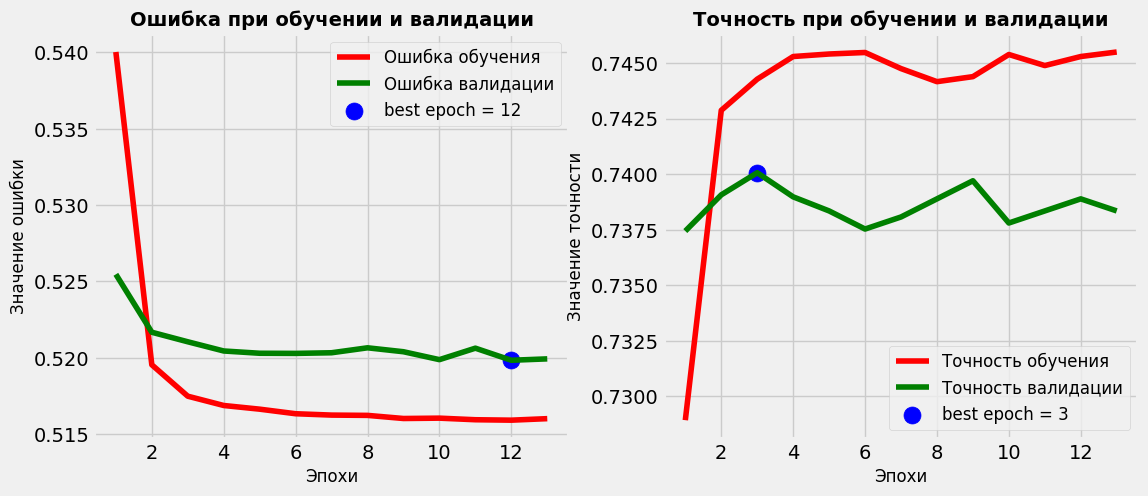

In [92]:
plot_training_curves(history1_new)

In [93]:
y_predicted_prob = model1_new.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

432/432 [==============================] - 1s 1ms/step


In [94]:
model1_new_performance = generate_performance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7371
Precision_score:	0.7273
Recall_score:		0.7987
AUC Score:		0.8119


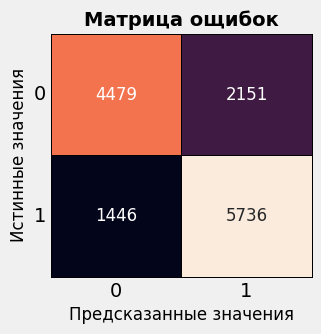

In [95]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

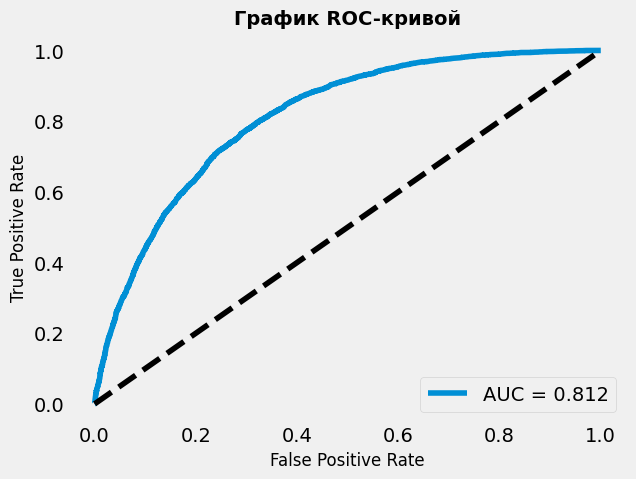

In [96]:
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [97]:
model2_new = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

In [98]:
# компиляция модели
model2_new.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model2_new.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 12)                84        
                                                                 
 dense_20 (Dense)            (None, 8)                 104       
                                                                 
 dense_21 (Dense)            (None, 4)                 36        
                                                                 
 dense_22 (Dense)            (None, 1)                 5         
                                                                 
Total params: 229 (916.00 Byte)
Trainable params: 229 (916.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [99]:
# обучение модели
history2_new = model2_new.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/50
1382/1382 [==============================] - 6s 2ms/step - loss: 0.5643 - accuracy: 0.7232 - val_loss: 0.5390 - val_accuracy: 0.7373
Epoch 2/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5286 - accuracy: 0.7436 - val_loss: 0.5286 - val_accuracy: 0.7376
Epoch 3/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5219 - accuracy: 0.7447 - val_loss: 0.5243 - val_accuracy: 0.7381
Epoch 4/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5194 - accuracy: 0.7447 - val_loss: 0.5232 - val_accuracy: 0.7366
Epoch 5/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5183 - accuracy: 0.7449 - val_loss: 0.5216 - val_accuracy: 0.7379
Epoch 6/50
1382/1382 [==============================] - 3s 2ms/step - loss: 0.5176 - accuracy: 0.7457 - val_loss: 0.5210 - val_accuracy: 0.7386
Epoch 7/50
1382/1382 [==============================] - 4s 3ms/step - loss: 0.5172 - accuracy: 0.7446 - val_loss: 0.5208 - val_accuracy:

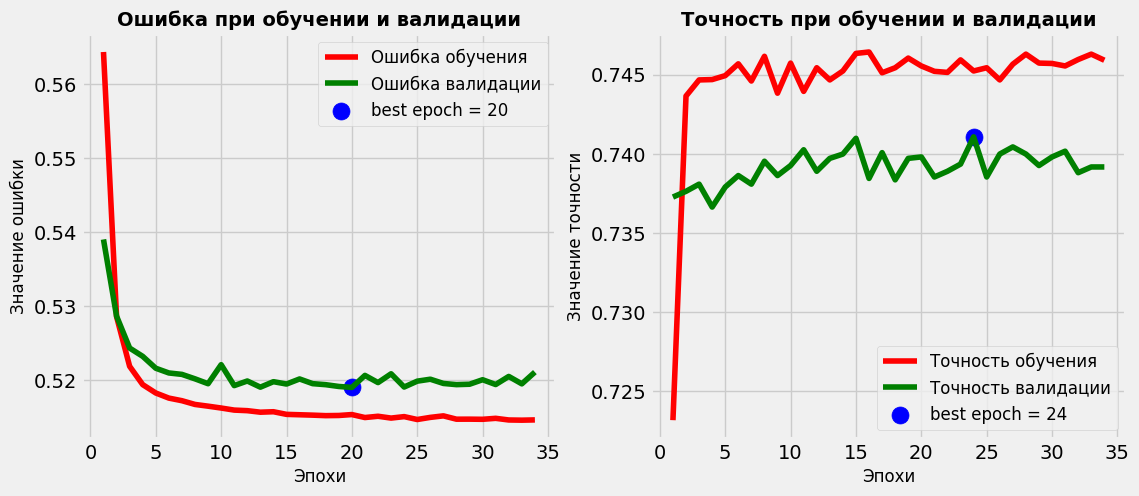

In [100]:
plot_training_curves(history2_new)

In [101]:
y_predicted_prob = model2_new.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

432/432 [==============================] - 1s 1ms/step


In [102]:
model2_new_performance = generate_performance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7339
Precision_score:	0.7139
Recall_score:		0.8266
AUC Score:		0.8128


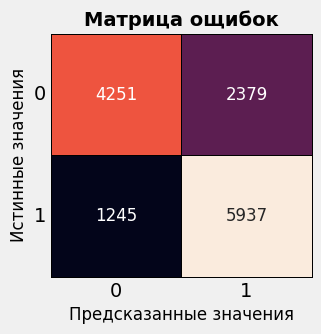

In [103]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

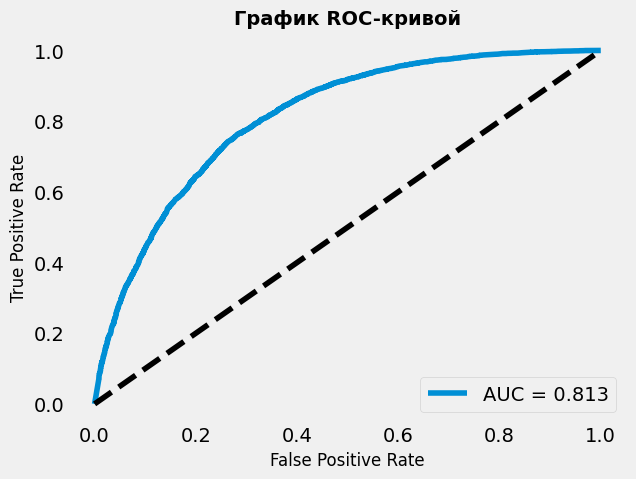

In [104]:
plot_roc_curve(y_test, y_predicted_prob)

In [105]:
# сведем результаты работы всех моделей в таблицу
performance_df = pd.DataFrame({
    'Модель 1': model1_performance,
    'Модель 2': model1_new_performance
}).T

performance_df

,accuracy_score,precision_score,recall_score,auc_score
Модель 1,0.744424,0.740513,0.787942,0.820635
Модель 2,0.737114,0.727273,0.798663,0.811859


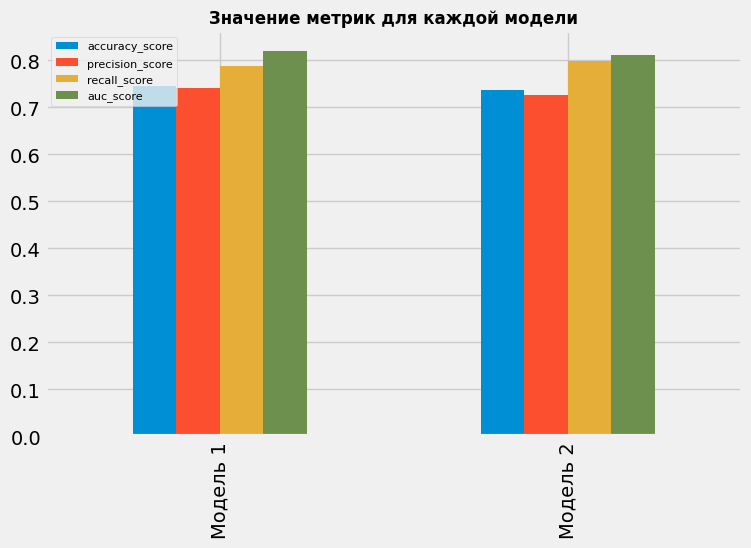

In [106]:
performance_df.plot(kind="bar", figsize=(8, 5))
plt.title('Значение метрик для каждой модели', fontsize=12, fontweight="bold");
plt.legend(loc=2, fontsize=8)